## Head

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from typing import List, Tuple

In [2]:
import pylift
import causalml.metrics as cmetrics

from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split

In [14]:
import sys
sys.path.append('../')
import pylift_utils

## Utils

In [ ]:
def uplift_at_k(
    predictions: pd.DataFrame,
    data: pd.DataFrame,
    col_target: str,
    col_id: str,
    col_treatment: str,
    ratio_top: float = 0.3
) -> float:
    assert len(predictions) == len(data)
    n_top = int(len(data) * ratio_top)
    top = (
        predictions
        .sort_values(by=['score'], ascending=False)
        .merge(data[[col_id, col_treatment, col_target]], on=[col_id], how='inner')
        .iloc[: n_top]
    )
    tmp = top.groupby(by=[col_treatment])[col_target].mean()
    return tmp.loc[1] - tmp.loc[0]

## Load'n'cook

### load

- **visit**: индикатор, 1 - клиент посетил сайт в последующие 2 недели после рассылки
- **conversion**: индикатор, 1 - клиент купил товары на сайте в последующие 2 недели после рассылки
- **spend**: количество $ потраченных на покупки в последующие 2 недели

In [7]:
data_womens = pd.read_csv('../data/hw1/minethatdata_womens_train.csv')
data_womens.head(2)

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0


In [16]:
data_womens_val = pd.read_csv('../data/hw1/minethatdata_womens_test_no_answers.csv')
data_womens_val.head(2)

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment
0,61726,2,1) $0 - $100,74.04,0,1,Urban,0,Phone,No E-Mail
1,57540,3,4) $350 - $500,435.14,1,0,Urban,1,Multichannel,Womens E-Mail


In [18]:
data_womens.segment.value_counts()

Womens E-Mail    10709
No E-Mail        10637
Name: segment, dtype: int64

In [17]:
data_womens_val.segment.value_counts()

Womens E-Mail    10678
No E-Mail        10669
Name: segment, dtype: int64

### transform

In [9]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

In [10]:
def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [19]:
data_womens = transform_(data_womens)
data_womens_val = transform_(data_womens_val)

In [20]:
data_womens['treatment'] = (data_womens['segment'] == 'Womens E-Mail').astype(int)
data_womens_val['treatment'] = (data_womens_val['segment'] == 'Womens E-Mail').astype(int)

### fit / validation split

In [21]:
treated_fit_index = data_womens[['treatment']].query('treatment == 1').index
treated_val_index = data_womens_val[['treatment']].query('treatment == 1').index

In [22]:
control_fit_index = data_womens[['treatment']].query('treatment == 0').index
control_val_index = data_womens_val[['treatment']].query('treatment == 0').index

### column sets

In [23]:
data_womens.columns

Index(['index', 'recency', 'history_segment', 'history', 'mens', 'womens',
       'zip_code', 'newbie', 'channel', 'segment', 'visit', 'conversion',
       'spend', 'zip_code_num', 'channel_num', 'history_segment__label',
       'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web',
       'history_segment__label_1', 'history_segment__label_2',
       'history_segment__label_3', 'history_segment__label_4',
       'history_segment__label_5', 'history_segment__label_6',
       'history_segment__label_7', 'treatment', 'zip_code_Rural',
       'zip_code_Surburban', 'zip_code_Urban', 'channel_Multichannel',
       'channel_Phone', 'channel_Web', 'history_segment__label_1',
       'history_segment__label_2', 'history_segment__label_3',
       'history_segment__label_4', 'history_segment__label_5',
       'history_segment__label_6', 'history_segment__label_7'],
      dtype='object')

In [24]:
column_set_n1 = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

## Main

### basic EDA

#### stats

In [56]:
stats = data_womens.pivot_table(
    values={
        'visit': 'mean',
        'conversion': 'mean',
        'spend': 'mean',
    },
    columns=['treatment']
)
stats['uplift'] = stats.loc[:, 1] - stats.loc[:, 0]
stats['uplift_perc'] = stats.loc[:, 1] / stats.loc[:, 0]
stats

treatment,0,1,uplift,uplift_perc
conversion,0.004983,0.008498,0.003515,1.705437
spend,0.583971,1.131093,0.547121,1.936898
visit,0.101720,0.148193,0.046473,1.456867


In [57]:
stats.reset_index(inplace=True)
stats.columns = ['variable', 'mean_control', 'mean_treated', 'ate', 'relative_change']
stats

,variable,mean_control,mean_treated,ate,relative_change
0,conversion,0.004983,0.008498,0.003515,1.705437
1,spend,0.583971,1.131093,0.547121,1.936898
2,visit,0.101720,0.148193,0.046473,1.456867


In [35]:
stats.to_csv('stat.csv', index=None)

#### confidence intervals

In [43]:
from tqdm import tqdm
def ate_bootstrapped(
    data: pd.DataFrame,
    col_value: str,
    treated_index: pd.Index,
    control_index: pd.Index,
    n_boot_iterations: int = 100
) -> Tuple[List[float], List[float]]:
    ates = list()
    pates = list()
    for _ in tqdm(range(n_boot_iterations), total=n_boot_iterations):
        sampled_index = np.concatenate([
            np.random.choice(treated_index, len(treated_index)),
            np.random.choice(control_index, len(control_index)),
        ])
        tmp = data.loc[sampled_index].groupby(by=['treatment'])[col_value].mean()
        ates.append(tmp.loc[1] - tmp.loc[0])
        pates.append(tmp.loc[1] / tmp.loc[0])
        
    return ates, pates

##### visit

In [65]:
visit_ates, visit_pates = ate_bootstrapped(
    data_womens,
    col_value='visit',
    treated_index=treated_fit_index,
    control_index=control_fit_index,
    n_boot_iterations=1000
)

100%|████████████████████| 1000/1000 [00:05<00:00, 196.39it/s]


0.0385103881356876 0.05360966118359483


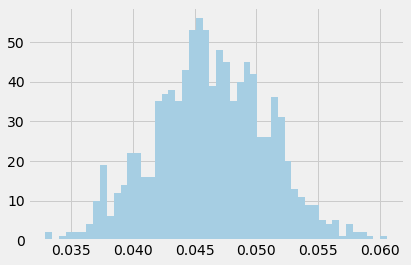

In [66]:
print(np.percentile(visit_ates, q=5), np.percentile(visit_ates, q=95))
plt.hist(visit_ates, bins=50)
plt.show()

1.3641446359114453 1.5448793264949527


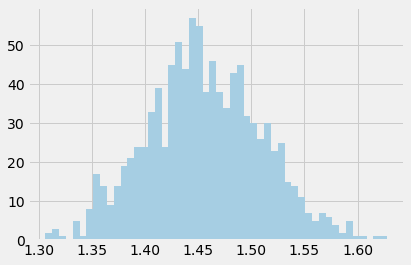

In [67]:
print(np.percentile(visit_pates, q=5), np.percentile(visit_pates, q=95))
plt.hist(visit_pates, bins=50)
plt.show()

In [58]:
with open('hw1_visit_ate_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (stats.loc['visit', 'uplift'], (np.percentile(visit_ates, q=5), np.percentile(visit_ates, q=95))),
        ofile
    )

KeyError: 'visit'

In [ ]:
with open('hw1_visit_rel_chg_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (
            stats.loc['visit', 'uplift_perc'],
            (np.percentile(visit_pates, q=5), np.percentile(visit_pates, q=95))
        ),
        ofile
    )

##### conversion

In [71]:
conversion_ates, conversion_pates = ate_bootstrapped(
    data_womens,
    col_value='conversion',
    treated_index=treated_fit_index,
    control_index=control_fit_index,
    n_boot_iterations=1000
)

100%|████████████████████| 1000/1000 [00:04<00:00, 200.06it/s]


0.0016484672816515589 0.0053825371812552284


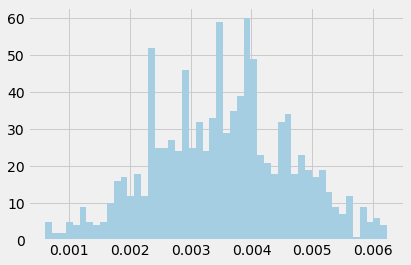

In [72]:
print(np.percentile(conversion_ates, q=5), np.percentile(conversion_ates, q=95))
plt.hist(conversion_ates, bins=50)
plt.show()

1.3002761970415209 2.297115697691563


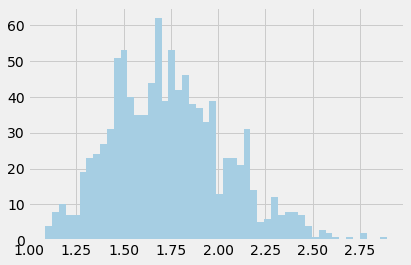

In [73]:
print(np.percentile(conversion_pates, q=5), np.percentile(conversion_pates, q=95))
plt.hist(conversion_pates, bins=50)
plt.show()

In [ ]:
with open('hw1_conversion_ate_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (stats.loc['conversion', 'uplift'], (np.percentile(conversion_ates, q=5), np.percentile(conversion_ates, q=95))),
        ofile
    )

In [ ]:
with open('hw1_conversion_rel_chg_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (
            stats.loc['conversion', 'uplift_perc'],
            (np.percentile(conversion_pates, q=5), np.percentile(conversion_pates, q=95))
        ),
        ofile
    )

##### spend

In [74]:
spend_ates, spend_pates = ate_bootstrapped(
    data_womens,
    col_value='spend',
    treated_index=treated_fit_index,
    control_index=control_fit_index,
    n_boot_iterations=1000
)

100%|████████████████████| 1000/1000 [00:05<00:00, 198.42it/s]


0.2388623770190356 0.8741390899821443


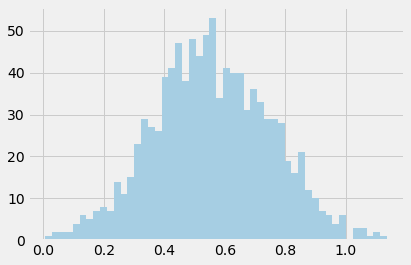

In [75]:
print(np.percentile(spend_ates, q=5), np.percentile(spend_ates, q=95))
plt.hist(spend_ates, bins=50)
plt.show()

1.3453606349425093 2.906632922471598


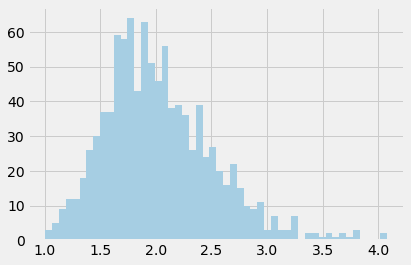

In [76]:
print(np.percentile(spend_pates, q=5), np.percentile(spend_pates, q=95))
plt.hist(spend_pates, bins=50)
plt.show()

In [ ]:
with open('hw1_spend_ate_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (stats.loc['spend', 'uplift'], (np.percentile(spend_ates, q=5), np.percentile(spend_ates, q=95))),
        ofile
    )

In [ ]:
with open('hw1_spend_rel_chg_confidence_interval.pkl', 'wb') as ofile:
    pickle.dump(
        (
            stats.loc['spend', 'uplift_perc'],
            (np.percentile(spend_pates, q=5), np.percentile(spend_pates, q=95))
        ),
        ofile
    )

### model

#### Обучение

In [110]:
column_set_n1

['recency', 'history', 'mens', 'womens', 'zip_code_num', 'channel_num']

In [112]:
column_set_n2 = [ 'recency', 'history_segment', 'history', 'mens', 'womens',
       'zip_code', 'newbie', 'channel', 'segment', 'zip_code_num',
       'channel_num', 'history_segment__label', 'zip_code_Rural',
       'zip_code_Surburban', 'zip_code_Urban', 'channel_Multichannel',
       'channel_Phone', 'channel_Web', 'history_segment__label_1',
       'history_segment__label_2', 'history_segment__label_3',
       'history_segment__label_4', 'history_segment__label_5',
       'history_segment__label_6', 'history_segment__label_7']

In [113]:
upmodel = UpliftRandomForestClassifier(
    control_name='control',
    n_estimators=10,
    max_depth=3,
    min_samples_leaf=500,
    random_state=165
)

In [117]:
column_set = column_set_n1

In [118]:
upmodel.fit(
    X=data_womens[column_set].values,
    treatment=data_womens['treatment'].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=data_womens['visit'].values
)

#### Прогноз

In [119]:
eval_data = data_womens_val.loc[:,column_set + ['treatment']]
eval_data['score'] = upmodel.predict(eval_data[column_set].values)
eval_data = eval_data[['score', 'treatment']]

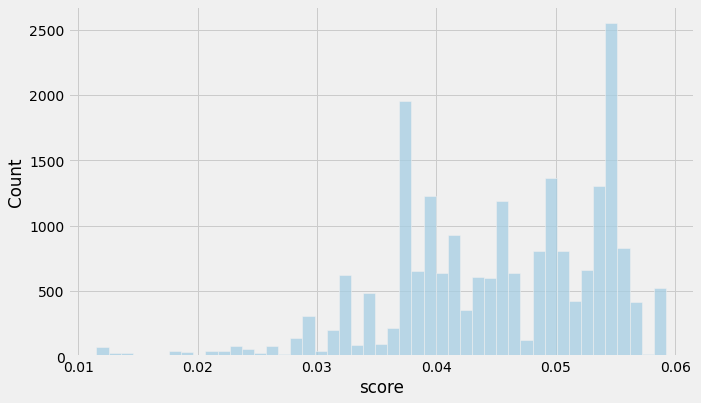

In [120]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

In [121]:
data_womens_val.head(2)

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,...,channel_Phone,channel_Web,history_segment__label_1,history_segment__label_2,history_segment__label_3,history_segment__label_4,history_segment__label_5,history_segment__label_6,history_segment__label_7,treatment
0,61726,2,1) $0 - $100,74.04,0,1,Urban,0,Phone,No E-Mail,...,1,0,1,0,0,0,0,0,0,0
1,57540,3,4) $350 - $500,435.14,1,0,Urban,1,Multichannel,Womens E-Mail,...,0,0,0,0,0,1,0,0,0,1


In [122]:
eval_data.head()

,score,treatment
0,0.046637,0
1,0.039457,1
2,0.054532,1
3,0.047399,0
4,0.036970,0


In [123]:
predictions = pd.merge(data_womens_val[['index']], eval_data[['score']], left_index=True, right_index=True)

In [124]:
predictions.to_csv('preds_hw1.csv', index=None)

#### Оценка качества

In [ ]:
uplift_at_k(
    predictions=eval_data.reset_index()[['index', 'score']],
    data=eval_data.reset_index()[['index', 'treatment', 'visit']],
    col_target='visit',
    col_id='index',
    col_treatment='treatment',
    ratio_top=0.3
)

0.06984682474310264

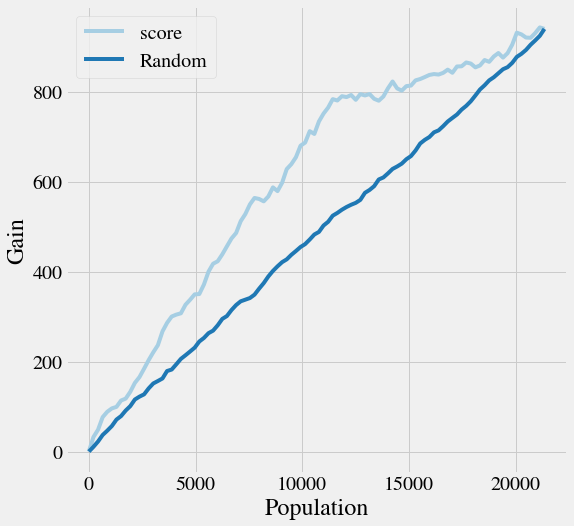

In [ ]:
cmetrics.plot_gain(
    eval_data,
    treatment_col='treatment',
    outcome_col='visit',
)

In [ ]:
cmetrics.auuc_score(
    eval_data,
    treatment_col='treatment',
    outcome_col='visit',
)

score     0.645654
Random    0.507763
dtype: float64

In [ ]:
upeval = pylift.eval.UpliftEval(
    treatment=eval_data['treatment'],
    outcome=eval_data['visit'],
    prediction=eval_data['score'],
    n_bins=5
)

No handles with labels found to put in legend.


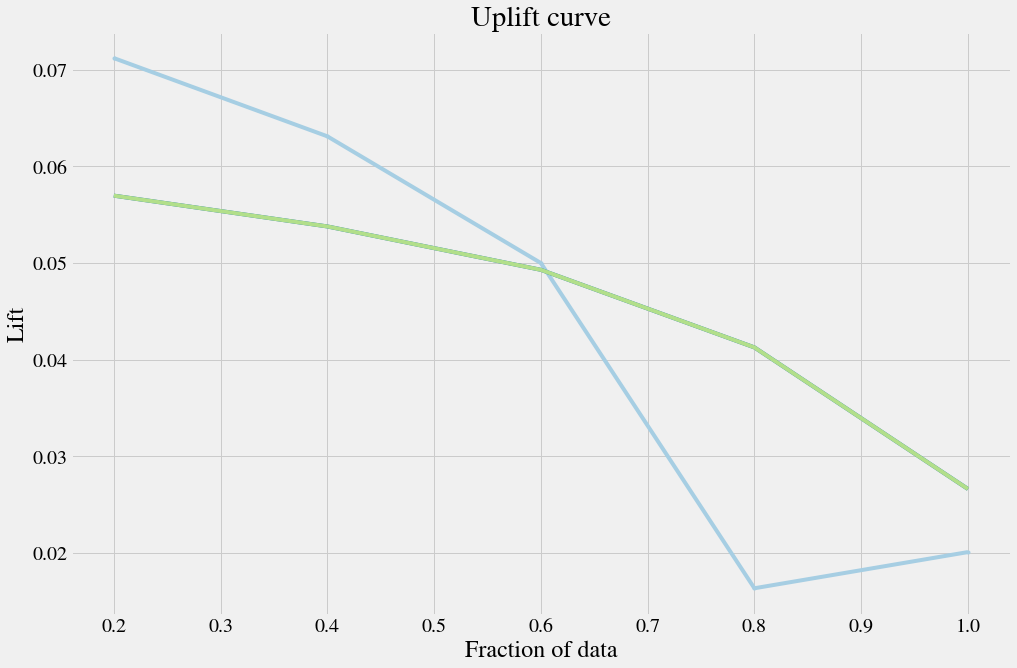

In [ ]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=5))